In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn import tree
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree

import gc
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from scipy import stats

In [2]:
def find_best_k_recall(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
    
    print("Best Value for k: {}".format(best_k))
    print("Recall-Score: {}".format(best_score))

In [3]:
column_defs = pd.read_excel('data\LCDataDictionary.xlsx',index_col='LoanStatNew')
column_defs.columns

Index(['Description'], dtype='object')

In [4]:
def column_info(col_name):
    return column_defs.loc[col_name]['Description']

In [5]:
def na_check(data):
    check = np.round(data.isna().sum().sort_values(ascending=False),2)
    return check

In [6]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm(cols):
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = check_if_integer(df[col])

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
df = pd.read_csv('data/full_clean')
df.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,mths_since_recent_inq,num_bc_tl,num_il_tl,num_op_rev_tl,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,0,12000.0,36 months,10.99,392.8,B,B2,4,RENT,60000.0,...,3.0,10.0,0.0,15.0,0.0,0.0,18100.0,0.0,722.0,South
1,1,4800.0,36 months,10.99,157.1,B,B2,2,MORTGAGE,39600.0,...,3.0,4.0,1.0,3.0,0.0,0.0,25700.0,0.0,757.0,South
2,2,27060.0,36 months,10.99,885.5,B,B2,10,OWN,55000.0,...,8.0,8.0,8.0,10.0,0.0,0.0,35700.0,33054.0,732.0,Midwest
3,3,12000.0,36 months,7.62,374.0,A,A3,3,MORTGAGE,96500.0,...,10.0,10.0,15.0,8.0,0.0,0.0,14800.0,53404.0,707.0,South
4,4,14000.0,36 months,12.85,470.8,B,B4,4,RENT,88000.0,...,0.0,9.0,3.0,4.0,1.0,0.0,3900.0,27340.0,672.0,South


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 34 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Unnamed: 0                  int64  
 1   loan_amnt                   float64
 2   term                        object 
 3   int_rate                    float64
 4   installment                 float64
 5   grade                       object 
 6   sub_grade                   object 
 7   emp_length                  int64  
 8   home_ownership              object 
 9   annual_inc                  float64
 10  verification_status         object 
 11  issue_d                     object 
 12  loan_status                 object 
 13  purpose                     object 
 14  dti                         float64
 15  delinq_2yrs                 float64
 16  earliest_cr_line            object 
 17  inq_last_6mths              float64
 18  pub_rec                     float64
 19  total_acc            

In [9]:
def sigmoid(x):
    x = np.array(x)
    if x != 0:
        sig = 1/(1 + np.e**(-1*x))
        return sig
    else: 
        return x

In [10]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [11]:
reduce_mem_usage(df,int_cast=False)

  0%|          | 0/33 [00:00<?, ?it/s]

Memory usage of dataframe is 437.31 MB


100%|██████████| 33/33 [00:01<00:00, 20.30it/s]


Memory usage after optimization is: 286.570 MB
Decreased by 34.5%


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,mths_since_recent_inq,num_bc_tl,num_il_tl,num_op_rev_tl,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,average_fico,region
0,12000.0,36 months,10.99,392.799988,B,B2,4,RENT,60000.0,Not Verified,...,3.0,10.0,0.0,15.0,0.0,0.0,18100.0,0.0,722.0,South
1,4800.0,36 months,10.99,157.100006,B,B2,2,MORTGAGE,39600.0,Source Verified,...,3.0,4.0,1.0,3.0,0.0,0.0,25700.0,0.0,757.0,South
2,27060.0,36 months,10.99,885.500000,B,B2,10,OWN,55000.0,Verified,...,8.0,8.0,8.0,10.0,0.0,0.0,35700.0,33054.0,732.0,Midwest
3,12000.0,36 months,7.62,374.000000,A,A3,3,MORTGAGE,96500.0,Not Verified,...,10.0,10.0,15.0,8.0,0.0,0.0,14800.0,53404.0,707.0,South
4,14000.0,36 months,12.85,470.799988,B,B4,4,RENT,88000.0,Not Verified,...,0.0,9.0,3.0,4.0,1.0,0.0,3900.0,27340.0,672.0,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736932,24000.0,60 months,23.99,690.500000,E,E2,1,RENT,107000.0,Source Verified,...,4.0,11.0,5.0,12.0,1.0,1.0,28200.0,64422.0,672.0,West
1736933,10000.0,36 months,7.99,313.200012,A,A5,10,MORTGAGE,65000.0,Source Verified,...,17.0,12.0,4.0,13.0,0.0,0.0,34800.0,70203.0,727.0,Northeast
1736934,10050.0,36 months,16.99,358.200012,D,D1,8,RENT,37000.0,Not Verified,...,2.0,4.0,3.0,15.0,0.0,0.0,9000.0,0.0,707.0,South
1736935,6000.0,36 months,11.44,197.800003,B,B4,5,RENT,41000.0,Source Verified,...,10.0,4.0,9.0,6.0,0.0,0.0,8100.0,34076.0,672.0,Northeast


In [ ]:
df.drop(columns=['sub_grade','issue_d','earliest_cr_line','last_pymnt_date'])

In [12]:
categorical =['term',
 'sub_grade','grade',
 'home_ownership',
 'verification_status',
 'purpose','application_type','region']

drop = ['issue_d','earliest_cr_line']
cat_drop = ['term',
 'sub_grade','grade'
 'home_ownership',
 'verification_status',
 'purpose',
 'region','application_type','issue_d','earliest_cr_line']
cat_drop1 = ['term',
 'sub_grade','grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'region','application_type','issue_d','earliest_cr_line','loan_status']

In [13]:
onehot = pd.get_dummies(df[categorical],drop_first=True)

In [14]:
cont = df.drop(columns=cat_drop1)
cont_columns = cont.columns



In [15]:
df[cont_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 22 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float32
 1   int_rate                    float32
 2   installment                 float32
 3   emp_length                  int8   
 4   annual_inc                  float32
 5   dti                         float32
 6   delinq_2yrs                 float32
 7   inq_last_6mths              float32
 8   pub_rec                     float32
 9   total_acc                   float32
 10  acc_open_past_24mths        float32
 11  delinq_amnt                 float32
 12  mort_acc                    float32
 13  mths_since_recent_inq       float32
 14  num_bc_tl                   float32
 15  num_il_tl                   float32
 16  num_op_rev_tl               float32
 17  pub_rec_bankruptcies        float32
 18  tax_liens                   float32
 19  total_bc_limit       

In [16]:
z_scores = stats.zscore(df[cont_columns])

In [17]:
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

In [ ]:
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [15]:
df_cont_z = df[(np.abs(stats.zscore(df[cont_columns]))<3).all(axis=1)]

In [16]:
z_score_df = df.loc[df_cont_z.index]

In [242]:
(1736937 - 1450262)/1736937

0.16504628550143155

In [240]:
len(z_score_df)

1450262

In [235]:
df_cont_z.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       9,      10,
            ...
            1736923, 1736924, 1736925, 1736926, 1736930, 1736931, 1736933,
            1736934, 1736935, 1736936],
           dtype='int64', length=1450262)

In [18]:
onehot_z = pd.get_dummies(z_score_df[categorical],drop_first=True)

In [19]:
cont_z = z_score_df.drop(columns=cat_drop1)


In [21]:
xz= pd.concat([cont_z,onehot_z],axis=1)
yz= z_score_df['loan_status'].map(lambda x: 1 if x== "Charged Off" else 0)

In [23]:
yz.value_counts(normalize=True)

0    0.808111
1    0.191889
Name: loan_status, dtype: float64

In [263]:
y_smote_z.value_counts()

1    820914
0    820914
Name: loan_status, dtype: int64

In [254]:
smote= SMOTENC(categorical_features=cat_index)
x_smote_z,y_smote_z = smote.fit_sample(x_train_z,y_train_z)

In [255]:
x_smote_z.to_csv('data/x_smote_z')
y_smote_z.to_csv('data/y_smote_z')

In [24]:
x_smote_z = pd.read_csv('data/x_smote_z')
y_smote_z = pd.read_csv('data/y_smote_z')

In [35]:
reduce_mem_usage(x_smote_z,int_cast=False)

  0%|          | 0/88 [00:00<?, ?it/s]

Memory usage of dataframe is 1102.30 MB


100%|██████████| 88/88 [00:12<00:00,  7.27it/s]


Memory usage after optimization is: 241.129 MB
Decreased by 78.1%


,Unnamed: 0,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,region_Northeast,region_South,region_West
0,0,6400.000000,6.030000,194.800003,3,71680.000000,19.549999,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,1,0,0
1,1,16000.000000,11.490000,527.500000,5,85000.000000,39.400002,0.0,1.000000,0.000000,...,0,0,0,0,0,0,1,0,1,0
2,2,8500.000000,15.610000,297.200012,1,93000.000000,3.380000,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
3,3,5000.000000,15.020000,173.399994,10,39000.000000,26.219999,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,4,9000.000000,6.990000,277.799988,10,46000.000000,12.420000,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641823,1641823,25083.533203,12.241467,836.761780,1,99807.968750,18.345182,0.0,0.192029,0.903985,...,0,0,0,0,0,0,0,0,0,0
1641824,1641824,18885.734375,21.542681,541.660889,5,42881.417969,13.569408,0.0,1.762834,0.118583,...,0,0,0,0,0,0,0,0,0,0
1641825,1641825,7614.354980,9.777097,245.245361,7,50618.816406,11.264113,0.0,1.000000,0.618817,...,0,0,0,0,0,0,0,0,0,0
1641826,1641826,14587.939453,18.977655,378.189972,1,40000.000000,22.618299,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [39]:
x_smote_z.drop('Unnamed: 0',axis=1,inplace=True)

In [40]:
x_smote_z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641828 entries, 0 to 1641827
Data columns (total 87 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1641828 non-null  float32
 1   int_rate                             1641828 non-null  float32
 2   installment                          1641828 non-null  float32
 3   emp_length                           1641828 non-null  int8   
 4   annual_inc                           1641828 non-null  float32
 5   dti                                  1641828 non-null  float32
 6   delinq_2yrs                          1641828 non-null  float32
 7   inq_last_6mths                       1641828 non-null  float32
 8   pub_rec                              1641828 non-null  float32
 9   total_acc                            1641828 non-null  float32
 10  acc_open_past_24mths                 1641828 non-null  float32
 11

In [36]:
reduce_mem_usage(y_smote_z,int_cast=False)

100%|██████████| 2/2 [00:00<00:00, 86.95it/s]

Memory usage of dataframe is 25.05 MB
Memory usage after optimization is: 7.829 MB
Decreased by 68.7%


,Unnamed: 0,loan_status
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1641823,1641823,1
1641824,1641824,1
1641825,1641825,1
1641826,1641826,1


In [38]:
y_smote_z.drop('Unnamed: 0',axis=1,inplace=True)

In [25]:
scaler = MinMaxScaler()

In [41]:

x_smote_cont_z =  pd.DataFrame(scaler.fit_transform(x_smote_z[cont_columns]),columns=cont_columns)

In [42]:
x_smote_scaled_z = pd.concat([x_smote_cont_z,x_smote_z[onehot.columns]],axis=1)

In [43]:
x_train_z, x_test_z, y_train_z, y_test_z = train_test_split(xz, yz, test_size=0.3)

In [44]:
#making validation x and y values
x_train_final_z, x_val_z, y_train_final_z, y_val_z = train_test_split(x_smote_scaled_z, y_smote_z, test_size=.3)

In [45]:
x_test_z= x_test_z.reset_index().drop('index',axis=1)

In [46]:
x_test_cont_scaled_z = pd.DataFrame(scaler.transform(x_test_z[cont_columns]),columns=cont_columns)
x_test_scaled_z = pd.concat([x_test_cont_scaled_z,x_test_z[onehot.columns]],axis=1)


In [34]:
x_smote_scaled_z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641828 entries, 0 to 1641827
Data columns (total 87 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1641828 non-null  float64
 1   int_rate                             1641828 non-null  float64
 2   installment                          1641828 non-null  float64
 3   emp_length                           1641828 non-null  float64
 4   annual_inc                           1641828 non-null  float64
 5   dti                                  1641828 non-null  float64
 6   delinq_2yrs                          1641828 non-null  float64
 7   inq_last_6mths                       1641828 non-null  float64
 8   pub_rec                              1641828 non-null  float64
 9   total_acc                            1641828 non-null  float64
 10  acc_open_past_24mths                 1641828 non-null  float64
 11

In [ ]:

x_smote_scaled = pd.concat([x_smote_cont_scaled,x_smote[onehot.columns]],axis=1)

In [19]:
x = pd.concat([cont,onehot],axis=1)
y= df['loan_status'].map(lambda x: 1 if x =="Charged Off" else 0)

In [20]:
x.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736937 entries, 0 to 1736936
Data columns (total 87 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   loan_amnt                            float32
 1   int_rate                             float32
 2   installment                          float32
 3   emp_length                           int8   
 4   annual_inc                           float32
 5   dti                                  float32
 6   delinq_2yrs                          float32
 7   inq_last_6mths                       float32
 8   pub_rec                              float32
 9   total_acc                            float32
 10  acc_open_past_24mths                 float32
 11  delinq_amnt                          float32
 12  mort_acc                             float32
 13  mths_since_recent_inq                float32
 14  num_bc_tl                            float32
 15  num_il_tl                       

In [21]:
cat_index = np.linspace(22,86,num=(86-22)).astype(np.int)

In [23]:
cat_index

array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86])

In [22]:
type(cat_index.astype(np.int))

numpy.ndarray

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [25]:
from imblearn.over_sampling import SMOTENC

In [26]:
cat_index.shape

(64,)

In [27]:
smote= SMOTENC(categorical_features=cat_index)

In [28]:
x_smote,y_smote = smote.fit_sample(x_train,y_train)

In [29]:
x_smote.to_csv('data/x_smote')
y_smote.to_csv('data/y_smote')

In [30]:
scaler = MinMaxScaler()
#cont_scaled = pd.DataFrame(scaler.fit_transform(cont),columns=cont_columns)

In [215]:
x_smote_cont_sig = x_smote[cont_columns].applymap(sigmoid)
x_smote_sig = pd.concat([x_smote_cont_sig,x_smote[onehot.columns]],axis=1)

In [216]:
#scaling cont feats for smote/ train data



In [ ]:
x_smote_cont_scaled = pd.DataFrame(scaler.fit_transform(x_smote[cont_columns]),columns=cont_columns)
x_smote_scaled = pd.concat([x_smote_cont_scaled,x_smote[onehot.columns]],axis=1)

In [32]:
na_check(x_smote_scaled)

region_West     0
sub_grade_B5    0
sub_grade_A2    0
sub_grade_A3    0
sub_grade_A4    0
               ..
grade_D         0
grade_E         0
grade_F         0
grade_G         0
loan_amnt       0
Length: 87, dtype: int64

In [33]:
x_test = x_test.reset_index().drop('index',axis=1)

In [217]:
x_test_cont_sig = x_test[cont_columns].applymap(sigmoid)

In [218]:
x_test_sig = pd.concat([x_test_cont_sig,x_test[onehot.columns]],axis=1)

In [274]:
#scaling cont feats for test data
x_test_cont_scaled = pd.DataFrame(scaler.transform(x_test[cont_columns]),columns=cont_columns)

#x_test_scaled = pd.concat([x_test_cont_scaled,x_test[onehot.columns]],axis=1)

In [35]:
x_test_scaled = pd.concat([x_test_cont_scaled,x_test[onehot.columns]],axis=1)

In [36]:
x_test_scaled.shape

(521082, 87)

In [37]:
x_smote_scaled.shape

(1959140, 87)

In [38]:
n_feats = x_smote_scaled.shape[1]
n_feats

87

In [39]:
#making validation x and y values
x_train_final, x_val, y_train_final, y_val = train_test_split(x_smote_scaled, y_smote, test_size=.3)

In [219]:
#making validation x and y values
x_train_final_sig, x_val_sig, y_train_final_1, y_val_1 = train_test_split(x_smote_sig, y_smote, test_size=.3)

In [32]:
sub_grade_columns = ['sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']

In [33]:
grade_columns = ['grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G']

all_grades = ['grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G','sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5']

pval_drops = ['home_ownership_NONE','home_ownership_OTHER','purpose_educational','delinq_amnt','tax_liens','sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5','annual_inc']

In [114]:
onehot.columns

Index(['term_ 60 months', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3',
       'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2',
       'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1',
       'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5',
       'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4',
       'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3',
       'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2',
       'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       

In [117]:
x_smote_scaled.drop(columns=sub_grade_columns,axis=1).head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,total_acc,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,region_Northeast,region_South,region_West
0,0.572821,0.042056,0.413727,1.000000,0.000773,0.02080,0.000000,0.000000,0.0,0.149425,...,0,0,0,0,0,0,0,0,1,0
1,0.258974,0.485203,0.230352,1.000000,0.000818,0.02952,0.000000,0.142857,0.0,0.258621,...,0,0,0,0,0,0,0,1,0,0
2,0.743590,0.275701,0.581358,0.333333,0.000845,0.01120,0.025641,0.000000,0.0,0.103448,...,0,0,0,0,0,0,0,0,1,0
3,0.743590,0.321262,0.400025,1.000000,0.000818,0.03053,0.000000,0.142857,0.0,0.189655,...,0,0,0,0,0,0,1,0,0,0
4,0.282051,0.312305,0.233967,1.000000,0.000636,0.02078,0.025641,0.000000,0.0,0.206897,...,0,0,0,0,0,0,0,0,1,0


In [49]:
len(pval_drops)

36

In [40]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Log Reg smote sig

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


AUC: 0.6457488751196597
[[296378  55189]
 [ 57268  26244]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84    351567
           1       0.32      0.31      0.32     83512

    accuracy                           0.74    435079
   macro avg       0.58      0.58      0.58    435079
weighted avg       0.74      0.74      0.74    435079



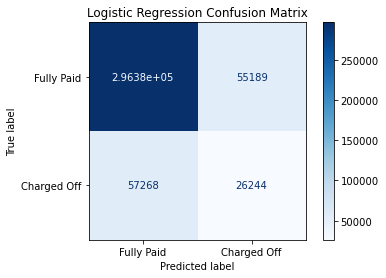

In [47]:
logreg = LogisticRegression(C=1e12,fit_intercept=False,solver='lbfgs',penalty='l2',max_iter=1500,verbose=1)
log_model = logreg.fit(x_train_final_z.drop(columns=sub_grade_columns,axis=1), y_train_final_z)
y_hat_log = logreg.predict(x_test_scaled_z.drop(columns=sub_grade_columns,axis=1))
y_score_log = log_model.decision_function(x_test_scaled_z.drop(columns=sub_grade_columns,axis=1))
fpr,tpr,thresholds = roc_curve(y_test_z,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled_z.drop(columns=sub_grade_columns,axis=1),y_test_z,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test_z, y_hat_log))
print(classification_report(y_test_z, y_hat_log))

In [44]:
forest = RandomForestClassifier()

In [ ]:
forest.fit(x_train_final_z.drop(columns=sub_grade_columns,axis=1),y_train_final_z)


In [45]:

y_pred_tree = forest.predict(x_test_scaled_z.drop(columns=sub_grade_columns,axis=1))

fpr, tpr, thresholds = roc_curve(y_test_z, y_pred_tree)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_pred_tree)

plot_confusion_matrix(forest,x_test_scaled_z.drop(columns=sub_grade_columns,axis=1),y_test_z,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Decision Tree Confusion Matrix")

print(confusion_matrix(y_test_z, y_pred_tree))
print(classification_report(y_test_z, y_pred_tree))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
knn.fit(x_train_final_z.drop(columns=sub_grade_columns,axis=1),y_train_final_z)

y_pred_knn = knn.predict(x_test_scaled_z.drop(columns=sub_grade_columns,axis=1))

fpr, tpr, thresholds = roc_curve(y_test_z, y_pred_knn)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test_z,y_pred_knn)

plot_confusion_matrix(knn,x_test_scaled_z.drop(columns=sub_grade_columns,axis=1),y_test_z,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Decision Tree Confusion Matrix")

print(confusion_matrix(y_test_z, y_pred_knn))
print(classification_report(y_test_z, y_pred_knn))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.3min finished


AUC: 0.622667158191716
[[361878  58394]
 [ 78008  22802]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84    420272
           1       0.28      0.23      0.25    100810

    accuracy                           0.74    521082
   macro avg       0.55      0.54      0.55    521082
weighted avg       0.72      0.74      0.73    521082



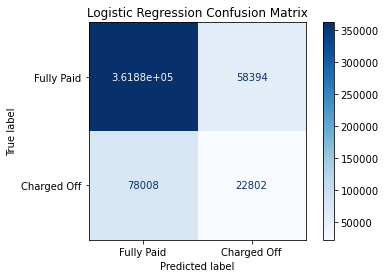

In [224]:
logreg = LogisticRegression(C=1e7,fit_intercept=False,solver='lbfgs',penalty='l2',max_iter=2500,verbose=1)
log_model = logreg.fit(x_train_final_sig.drop(columns=sub_grade_columns,axis=1), y_train_final_1)
y_hat_log = logreg.predict(x_test_sig.drop(columns=sub_grade_columns,axis=1))
y_score_log = log_model.decision_function(x_test_sig.drop(columns=sub_grade_columns,axis=1))
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_sig.drop(columns=sub_grade_columns,axis=1),y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log))

## Log Reg Smote Scaled Min Max

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


AUC: 0.6614425417887148
[[358010  62262]
 [ 69467  31343]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84    420272
           1       0.33      0.31      0.32    100810

    accuracy                           0.75    521082
   macro avg       0.59      0.58      0.58    521082
weighted avg       0.74      0.75      0.74    521082



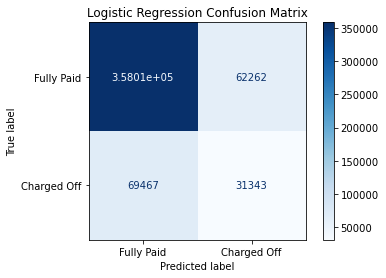

In [207]:
logreg = LogisticRegression(C=1e7,fit_intercept=False,solver='lbfgs',penalty='l2',max_iter=1500,verbose=1)
log_model = logreg.fit(x_train_final.drop(columns=pval_drops,axis=1), y_train_final)
y_hat_log = logreg.predict(x_test_scaled.drop(columns=pval_drops,axis=1))
y_score_log = log_model.decision_function(x_test_scaled.drop(columns=pval_drops,axis=1))
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled.drop(columns=pval_drops,axis=1),y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log)) 

In [ ]:
bad_p_values = 'home_ownership_NONE','home_ownership_OTHER','purpose_educational','delinq_amnt','tax_liens','annual_inc'

In [52]:
import statsmodels.api as sm

In [55]:
logit_model=sm.Logit(y_train_final_z,x_train_final_z.drop(columns=sub_grade_columns,axis=1))
result=logit_model.fit(method='bfgs',maxiter=1300)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.446989
         Iterations: 314
         Function evaluations: 316
         Gradient evaluations: 316


C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:              1149279
Model:                          Logit   Df Residuals:                  1149227
Method:                           MLE   Df Model:                           51
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:                  0.3551
Time:                        11:55:43   Log-Likelihood:            -5.1371e+05
converged:                       True   LL-Null:                   -7.9662e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
loan_amnt                               1.0215        nan        nan        nan         nan         nan
int_rate                                6.6460        na

AUC: 0.660874126574027
[[332552  87720]
 [ 59199  41611]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.82    420272
           1       0.32      0.41      0.36    100810

    accuracy                           0.72    521082
   macro avg       0.59      0.60      0.59    521082
weighted avg       0.75      0.72      0.73    521082



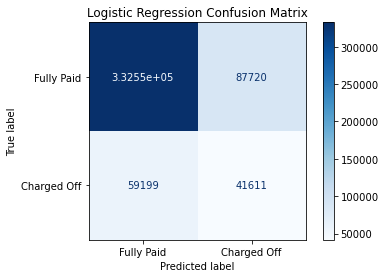

In [130]:
logreg = LogisticRegression(C=1e12,fit_intercept=False,solver='liblinear',penalty='l2',max_iter=300)
log_model = logreg.fit(x_smote_scaled.drop(columns=all_grades,axis=1), y_smote)
y_hat_log = logreg.predict(x_test_scaled.drop(columns=all_grades,axis=1))
y_score_log = log_model.decision_function(x_test_scaled.drop(columns=all_grades,axis=1))
fpr,tpr,thresholds = roc_curve(y_test,y_score_log)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_log)

plot_confusion_matrix(log_model,x_test_scaled.drop(columns=all_grades,axis=1),y_test,cmap=plt.cm.Blues,
                     display_labels=["Fully Paid", "Charged Off"],
                      values_format=".5g")
plt.title("Logistic Regression Confusion Matrix")

print(confusion_matrix(y_test, y_hat_log))
print(classification_report(y_test, y_hat_log)) 

## Baseline ANN -  Tanh activation with sigmoid output

In [54]:
y_train_final.shape

(1371398,)

In [92]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_model(n_layers, trainX, trainy, testX, testy,xval,yval):
# configure the model based on the data
    n_input, n_classes = trainX.shape[1], 1
    # define model
    model = models.Sequential()
    model.add(layers.Dense(50, input_dim=n_input, activation='tanh'))
    for _ in range(1, n_layers):
        model.add(layers.Dense(25, activation='tanh'))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX, trainy, epochs=100,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval,yval))
    # evaluate model on test set
    saved= load_model('best_model.h5')
    _, test_acc = saved.evaluate(testX, testy, verbose=1)
    return history, test_acc

Epoch 1/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2998 - acc: 0.8684 - val_loss: 0.3080 - val_acc: 0.8641
Epoch 2/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2923 - acc: 0.8716 - val_loss: 0.2920 - val_acc: 0.8716
Epoch 3/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2904 - acc: 0.8729 - val_loss: 0.2881 - val_acc: 0.8736
Epoch 4/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2889 - acc: 0.8736 - val_loss: 0.2875 - val_acc: 0.8743
Epoch 5/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2880 - acc: 0.8743 - val_loss: 0.2864 - val_acc: 0.8750
Epoch 6/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2874 - acc: 0.8746 - val_loss: 0.2868 - val_acc: 0.8752
Epoch 7/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.2868 - acc: 0.8749 - val_loss: 0.2880 - val_acc: 0.8736
Epoch 8/100
5358/5358 [==============================] 

Epoch 9/100
5358/5358 [==============================] - 13s 2ms/step - loss: 0.2868 - acc: 0.8749 - val_loss: 0.2865 - val_acc: 0.8757
Epoch 10/100
5358/5358 [==============================] - 13s 2ms/step - loss: 0.2866 - acc: 0.8751 - val_loss: 0.2870 - val_acc: 0.8750
Epoch 11/100
5358/5358 [==============================] - 18s 3ms/step - loss: 0.2863 - acc: 0.8752 - val_loss: 0.2862 - val_acc: 0.8756
Epoch 12/100
5358/5358 [==============================] - 13s 2ms/step - loss: 0.2861 - acc: 0.8753 - val_loss: 0.2856 - val_acc: 0.8756
Epoch 13/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.2858 - acc: 0.8755 - val_loss: 0.2857 - val_acc: 0.8759
Epoch 14/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.2857 - acc: 0.8755 - val_loss: 0.2860 - val_acc: 0.8740
Epoch 15/100
5358/5358 [==============================] - 14s 3ms/step - loss: 0.2856 - acc: 0.8755 - val_loss: 0.2853 - val_acc: 0.8765
Epoch 16/100
5358/5358 [==================

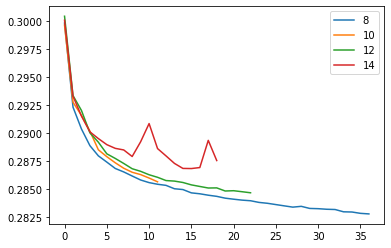

In [95]:
# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [8,10,12,14]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final,y_train_final, x_test_scaled, y_test,x_val,y_val)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [152]:
history.history

{'loss': [0.3791448473930359,
  0.3574574887752533,
  0.3461572527885437,
  0.3422376811504364,
  0.33967745304107666,
  0.3376535177230835,
  0.3367915749549866,
  0.3355250954627991,
  0.3348216712474823,
  0.3343983590602875,
  0.3333751857280731,
  0.3317030668258667,
  0.3259195387363434,
  0.3233402371406555,
  0.32227566838264465,
  0.32148557901382446,
  0.32030773162841797,
  0.3194274306297302,
  0.318688303232193,
  0.3183433413505554,
  0.31776878237724304,
  0.31687411665916443,
  0.3161795139312744,
  0.3154022693634033,
  0.3151480555534363,
  0.31455209851264954,
  0.31431132555007935,
  0.31365951895713806,
  0.3135871887207031,
  0.3132961690425873,
  0.3129062354564667,
  0.3124050796031952,
  0.312195360660553,
  0.31200408935546875],
 'acc': [0.8204882740974426,
  0.8334232568740845,
  0.8394900560379028,
  0.8415040969848633,
  0.843217670917511,
  0.8442443609237671,
  0.8446155190467834,
  0.8454788327217102,
  0.8458383083343506,
  0.8461066484451294,
  0.84676

Epoch 1/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3846 - acc: 0.8174 - val_loss: 0.3630 - val_acc: 0.8300
Epoch 2/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3618 - acc: 0.8306 - val_loss: 0.3556 - val_acc: 0.8344
Epoch 3/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3536 - acc: 0.8359 - val_loss: 0.3454 - val_acc: 0.8405
Epoch 4/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3444 - acc: 0.8408 - val_loss: 0.3444 - val_acc: 0.8394
Epoch 5/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3405 - acc: 0.8427 - val_loss: 0.3419 - val_acc: 0.8413
Epoch 6/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3381 - acc: 0.8439 - val_loss: 0.3353 - val_acc: 0.8451
Epoch 7/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3364 - acc: 0.8451 - val_loss: 0.3341 - val_acc: 0.8459
Epoch 8/100
5358/5358 [=========================

5358/5358 [==============================] - 9s 2ms/step - loss: 0.3345 - acc: 0.8460 - val_loss: 0.3361 - val_acc: 0.8453
Epoch 10/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3338 - acc: 0.8464 - val_loss: 0.3348 - val_acc: 0.8454
Epoch 11/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3332 - acc: 0.8467 - val_loss: 0.3303 - val_acc: 0.8482
Epoch 12/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3325 - acc: 0.8473 - val_loss: 0.3308 - val_acc: 0.8471
Epoch 13/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3320 - acc: 0.8476 - val_loss: 0.3323 - val_acc: 0.8476
Epoch 14/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3313 - acc: 0.8480 - val_loss: 0.3301 - val_acc: 0.8485
Epoch 15/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3310 - acc: 0.8481 - val_loss: 0.3310 - val_acc: 0.8482
Epoch 16/100
5358/5358 [==============================] - 9s 

Epoch 18/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3223 - acc: 0.8534 - val_loss: 0.3220 - val_acc: 0.8539
Epoch 19/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3215 - acc: 0.8539 - val_loss: 0.3190 - val_acc: 0.8554
Epoch 20/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3208 - acc: 0.8544 - val_loss: 0.3218 - val_acc: 0.8529
Epoch 21/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3205 - acc: 0.8547 - val_loss: 0.3223 - val_acc: 0.8530
Epoch 22/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3200 - acc: 0.8548 - val_loss: 0.3197 - val_acc: 0.8547
Epoch 23/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3196 - acc: 0.8551 - val_loss: 0.3205 - val_acc: 0.8542
Epoch 24/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3190 - acc: 0.8554 - val_loss: 0.3175 - val_acc: 0.8560
Epoch 25/100
5358/5358 [=================

5358/5358 [==============================] - 12s 2ms/step - loss: 0.3226 - acc: 0.8533 - val_loss: 0.3207 - val_acc: 0.8519
Epoch 18/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3208 - acc: 0.8543 - val_loss: 0.3216 - val_acc: 0.8551
Epoch 19/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3419 - acc: 0.8441 - val_loss: 0.3250 - val_acc: 0.8528
Epoch 20/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3200 - acc: 0.8552 - val_loss: 0.3170 - val_acc: 0.8565
Epoch 21/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3187 - acc: 0.8559 - val_loss: 0.3186 - val_acc: 0.8545
Epoch 22/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3177 - acc: 0.8563 - val_loss: 0.3228 - val_acc: 0.8536
Epoch 23/100
5358/5358 [==============================] - 12s 2ms/step - loss: 0.3176 - acc: 0.8563 - val_loss: 0.3153 - val_acc: 0.8575
Epoch 24/100
5358/5358 [==============================

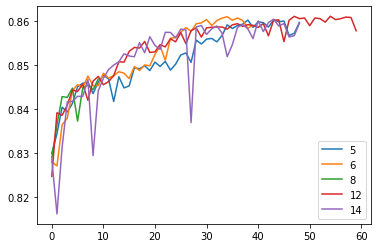

In [154]:
# evaluate model and plot learning curve of model with given number of layers
all_history = list()
num_layers = [5,6,8,12,14]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)    
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['val_acc'], label=str(n_layers))
plt.legend()
plt.show()

In [86]:
from keras.optimizers import Adam
from keras.optimizers import SGD

In [65]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:

baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50,activation='tanh',input_shape=(n_feats,)))
baseline_model.add(layers.Dense(25,activation='tanh'))
baseline_model.add(layers.Dense(25,activation='tanh'))
baseline_model.add(layers.Dense(1,activation='sigmoid'))

In [66]:
baseline_model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=25), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [47]:
results_1 = baseline_model.fit(x_train_final,y_train_final,
                               epochs=150,batch_size=256,callbacks=early_stopping,validation_data=(x_val,y_val))

Epoch 1/150
5360/5360 [==============================] - 7s 1ms/step - loss: 0.3792 - acc: 0.8374 - val_loss: 0.3034 - val_acc: 0.8763
Epoch 2/150
5360/5360 [==============================] - 6s 1ms/step - loss: 0.2987 - acc: 0.8754 - val_loss: 0.2940 - val_acc: 0.8779
Epoch 3/150
5360/5360 [==============================] - 6s 1ms/step - loss: 0.2942 - acc: 0.8765 - val_loss: 0.2911 - val_acc: 0.8777
Epoch 4/150
5360/5360 [==============================] - 7s 1ms/step - loss: 0.2924 - acc: 0.8766 - val_loss: 0.2898 - val_acc: 0.8777
Epoch 5/150
5360/5360 [==============================] - 6s 1ms/step - loss: 0.2913 - acc: 0.8768 - val_loss: 0.2894 - val_acc: 0.8782
Epoch 6/150
5360/5360 [==============================] - 6s 1ms/step - loss: 0.2906 - acc: 0.8768 - val_loss: 0.2886 - val_acc: 0.8783
Epoch 7/150
5360/5360 [==============================] - 6s 1ms/step - loss: 0.2898 - acc: 0.8769 - val_loss: 0.2876 - val_acc: 0.8780
Epoch 8/150
5360/5360 [==============================] 

5360/5360 [==============================] - 8s 1ms/step - loss: 0.2815 - acc: 0.8789 - val_loss: 0.2804 - val_acc: 0.8796
Epoch 62/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2815 - acc: 0.8789 - val_loss: 0.2801 - val_acc: 0.8796
Epoch 63/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2815 - acc: 0.8790 - val_loss: 0.2801 - val_acc: 0.8797
Epoch 64/150
5360/5360 [==============================] - 7s 1ms/step - loss: 0.2814 - acc: 0.8789 - val_loss: 0.2800 - val_acc: 0.8797
Epoch 65/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2814 - acc: 0.8790 - val_loss: 0.2801 - val_acc: 0.8797
Epoch 66/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2814 - acc: 0.8790 - val_loss: 0.2799 - val_acc: 0.8797
Epoch 67/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2813 - acc: 0.8789 - val_loss: 0.2799 - val_acc: 0.8797
Epoch 68/150
5360/5360 [==============================] - 8s 

5360/5360 [==============================] - 7s 1ms/step - loss: 0.2800 - acc: 0.8792 - val_loss: 0.2788 - val_acc: 0.8801
Epoch 122/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2800 - acc: 0.8792 - val_loss: 0.2793 - val_acc: 0.8800
Epoch 123/150
5360/5360 [==============================] - 7s 1ms/step - loss: 0.2800 - acc: 0.8794 - val_loss: 0.2791 - val_acc: 0.8799
Epoch 124/150
5360/5360 [==============================] - 7s 1ms/step - loss: 0.2800 - acc: 0.8793 - val_loss: 0.2789 - val_acc: 0.8801
Epoch 125/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2800 - acc: 0.8793 - val_loss: 0.2788 - val_acc: 0.8800
Epoch 126/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2799 - acc: 0.8793 - val_loss: 0.2799 - val_acc: 0.8794
Epoch 127/150
5360/5360 [==============================] - 8s 1ms/step - loss: 0.2799 - acc: 0.8793 - val_loss: 0.2788 - val_acc: 0.8801
Epoch 128/150
5360/5360 [==============================

In [48]:


saved_model = load_model('best_model.h5')

In [49]:
saved_model = load_model('best_model.h5')
results_train = saved_model.evaluate(x_train_final, y_train_final)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(x_test, y_test)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

42877/42877 [==============================] - 21s 498us/step - loss: 0.2793 - acc: 0.8795
Training Loss: 0.279 
Training Accuracy: 0.88
----------
16284/16284 [==============================] - 13s 822us/step - loss: 1.7487 - acc: 0.8056
Test Loss: 1.75 
Test Accuracy: 0.806


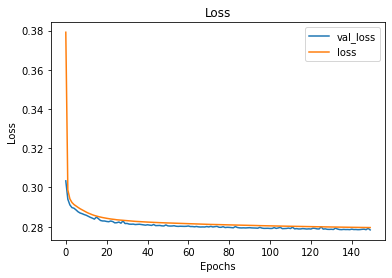

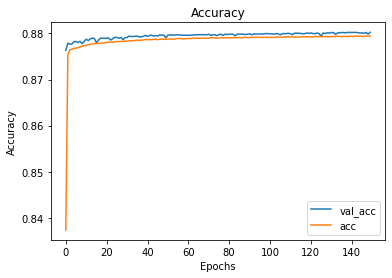

In [50]:
visualize_training_results(results_1)

In [51]:
base_preds_train = baseline_model.predict_classes(x_smote_scaled)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [52]:
base_preds_train.shape

(1960092, 1)

In [53]:

print(confusion_matrix(y_smote, base_preds_train))
print(classification_report(y_smote, base_preds_train))

[[966999  13047]
 [222652 757394]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    980046
           1       0.98      0.77      0.87    980046

    accuracy                           0.88   1960092
   macro avg       0.90      0.88      0.88   1960092
weighted avg       0.90      0.88      0.88   1960092



In [54]:
test_preds = baseline_model.predict_classes(x_test_scaled)

In [55]:

print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[414076   5720]
 [ 95095   6191]]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    419796
           1       0.52      0.06      0.11    101286

    accuracy                           0.81    521082
   macro avg       0.67      0.52      0.50    521082
weighted avg       0.76      0.81      0.74    521082



In [ ]:
base_preds_test = baseline_model.predict_classes()

## Dropout

In [56]:
dropout = models.Sequential()
dropout.add(layers.Dropout(.3,input_shape=(n_feats,)))
dropout.add(layers.Dense(50,activation='tanh',))
dropout.add(layers.Dropout(.3))
dropout.add(layers.Dense(40,activation='tanh'))
dropout.add(layers.Dropout(.3))
dropout.add(layers.Dense(25,activation='tanh'))
dropout.add(layers.Dropout(.2))
dropout.add(layers.Dense(1,activation='sigmoid'))

In [57]:
dropout.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['acc'])
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [58]:
results_drop = dropout.fit(x_train_final,y_train_final,
                               epochs=150,batch_size=256,callbacks=early_stopping,validation_data=(x_val,y_val))

Epoch 1/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.5401 - acc: 0.7431 - val_loss: 0.3777 - val_acc: 0.8651
Epoch 2/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.4639 - acc: 0.8044 - val_loss: 0.3545 - val_acc: 0.8704
Epoch 3/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.4466 - acc: 0.8136 - val_loss: 0.3472 - val_acc: 0.8696
Epoch 4/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.4379 - acc: 0.8179 - val_loss: 0.3438 - val_acc: 0.8689
Epoch 5/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.4326 - acc: 0.8204 - val_loss: 0.3390 - val_acc: 0.8685
Epoch 6/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.4293 - acc: 0.8214 - val_loss: 0.3394 - val_acc: 0.8666
Epoch 7/150
5360/5360 [==============================] - 13s 2ms/step - loss: 0.4263 - acc: 0.8226 - val_loss: 0.3401 - val_acc: 0.8661
Epoch 8/150
5360/5360 [=========================

## Testing Layers

In [101]:
x_train_final.shape[1]

87

In [134]:
x_train_final.drop(columns=sub_grade_columns,axis=1).shape

(1371398, 53)

In [136]:
n_lays = 20
model = models.Sequential()
model.add(layers.Dense(50, input_shape=(53,), activation='tanh'))
for _ in range(1, n_lays):
    model.add(layers.Dense(25, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history_20 = model.fit(x_train_final.drop(columns=sub_grade_columns,axis=1),
                       y_train_final, epochs=100,batch_size=256, verbose=1,callbacks=early_stopping,
                       validation_data=(x_val.drop(columns=sub_grade_columns,axis=1),y_val))



Epoch 1/100
5358/5358 [==============================] - 15s 3ms/step - loss: 0.3802 - acc: 0.8199 - val_loss: 0.3670 - val_acc: 0.8262
Epoch 2/100
5358/5358 [==============================] - 15s 3ms/step - loss: 0.3657 - acc: 0.8277 - val_loss: 0.4019 - val_acc: 0.8167
Epoch 3/100
5358/5358 [==============================] - 16s 3ms/step - loss: 0.3615 - acc: 0.8305 - val_loss: 0.3556 - val_acc: 0.8346
Epoch 4/100
5358/5358 [==============================] - 15s 3ms/step - loss: 0.3536 - acc: 0.8354 - val_loss: 0.3436 - val_acc: 0.8409
Epoch 5/100
5358/5358 [==============================] - 14s 3ms/step - loss: 0.3438 - acc: 0.8409 - val_loss: 0.3540 - val_acc: 0.8314
Epoch 6/100
5358/5358 [==============================] - 14s 3ms/step - loss: 0.3406 - acc: 0.8429 - val_loss: 0.3399 - val_acc: 0.8413
Epoch 7/100
5358/5358 [==============================] - 14s 3ms/step - loss: 0.3396 - acc: 0.8435 - val_loss: 0.3394 - val_acc: 0.8432
Epoch 8/100
5358/5358 [=========================

In [138]:
saved_model = load_model('best_model.h5')
results_train = saved_model.evaluate(x_train_final.drop(columns=sub_grade_columns,axis=1), y_train_final)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

42857/42857 [==============================] - 35s 811us/step - loss: 0.3193 - acc: 0.8561
Training Loss: 0.319 
Training Accuracy: 0.856
----------
16284/16284 [==============================] - 12s 754us/step - loss: 0.4584 - acc: 0.7986
Test Loss: 0.458 
Test Accuracy: 0.799


In [139]:
test_preds = saved_model.predict_classes(x_test_scaled.drop(columns=sub_grade_columns,axis=1))
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[405565  14707]
 [ 90224  10586]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89    420272
           1       0.42      0.11      0.17    100810

    accuracy                           0.80    521082
   macro avg       0.62      0.54      0.53    521082
weighted avg       0.74      0.80      0.75    521082



In [108]:
n_lays = 8
model = models.Sequential()
model.add(layers.Dense(300, input_shape=(n_feats,), activation='tanh'))
for _ in range(1, n_lays):
    model.add(layers.Dense(100, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history_8 = model.fit(x_train_final,y_train_final, epochs=100,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(x_val,y_val))



Epoch 1/100
5358/5358 [==============================] - 21s 4ms/step - loss: 0.2991 - acc: 0.8688 - val_loss: 0.2945 - val_acc: 0.8700
Epoch 2/100
5358/5358 [==============================] - 20s 4ms/step - loss: 0.2939 - acc: 0.8709 - val_loss: 0.2903 - val_acc: 0.8719
Epoch 3/100
5358/5358 [==============================] - 19s 4ms/step - loss: 0.2921 - acc: 0.8721 - val_loss: 0.2926 - val_acc: 0.8717
Epoch 4/100
5358/5358 [==============================] - 21s 4ms/step - loss: 0.2912 - acc: 0.8728 - val_loss: 0.2889 - val_acc: 0.8733
Epoch 5/100
5358/5358 [==============================] - 21s 4ms/step - loss: 0.2924 - acc: 0.8722 - val_loss: 0.2904 - val_acc: 0.8726
Epoch 6/100
5358/5358 [==============================] - 21s 4ms/step - loss: 0.2912 - acc: 0.8732 - val_loss: 0.2947 - val_acc: 0.8717
Epoch 7/100
5358/5358 [==============================] - 20s 4ms/step - loss: 0.2919 - acc: 0.8728 - val_loss: 0.2898 - val_acc: 0.8730
Epoch 8/100
5358/5358 [=========================

In [109]:
def test_class_report(saved_model_name,x_test,y_test,x_train,y_train):
    model = load_model(saved_model_name)
    train = model.evaluate(x_train,y_train)
    print(f'Training Loss: {train[0]:.3} \nTraining Accuracy: {train[1]:.3}')
    print('----------')
    test = model.evaluate(x_test,y_test)
    print(f'Test Loss: {test[0]:.3} \nTest Accuracy: {test[1]:.3}')
    preds = model.predict_classes(x_test)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    

In [110]:
test_class_report('best_model.h5',x_test_scaled,y_test,x_train_final,y_train_final)

42857/42857 [==============================] - 36s 828us/step - loss: 0.2880 - acc: 0.8746
Training Loss: 0.288 
Training Accuracy: 0.875
----------
16284/16284 [==============================] - 14s 842us/step - loss: 0.4501 - acc: 0.8063
Test Loss: 0.45 
Test Accuracy: 0.806
[[412498   7774]
 [ 93135   7675]]
              precision    recall  f1-score   support

           0       0.82      0.98      0.89    420272
           1       0.50      0.08      0.13    100810

    accuracy                           0.81    521082
   macro avg       0.66      0.53      0.51    521082
weighted avg       0.75      0.81      0.74    521082



In [140]:
n_lays = 8
opt = Adam(learning_rate=.025)
model = models.Sequential()
model.add(layers.Dense(50, input_shape=(53,), activation='relu'))
for _ in range(1, n_lays):
    model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history_20 = model.fit(x_train_final.drop(columns=sub_grade_columns,axis=1),
                       y_train_final, epochs=100,batch_size=256, verbose=1,callbacks=early_stopping,
                       validation_data=(x_val.drop(columns=sub_grade_columns,axis=1),y_val))


Epoch 1/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3778 - acc: 0.8218 - val_loss: 0.3604 - val_acc: 0.8293
Epoch 2/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3548 - acc: 0.8355 - val_loss: 0.3510 - val_acc: 0.8402
Epoch 3/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3449 - acc: 0.8410 - val_loss: 0.3413 - val_acc: 0.8427
Epoch 4/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3418 - acc: 0.8428 - val_loss: 0.3395 - val_acc: 0.8437
Epoch 5/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3383 - acc: 0.8446 - val_loss: 0.3428 - val_acc: 0.8442
Epoch 6/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3341 - acc: 0.8468 - val_loss: 0.3325 - val_acc: 0.8480
Epoch 7/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3410 - acc: 0.8434 - val_loss: 0.3954 - val_acc: 0.8090
Epoch 8/100
5358/5358 [=========================

In [141]:
saved_model = load_model('best_model.h5')
results_train = saved_model.evaluate(x_train_final.drop(columns=sub_grade_columns,axis=1), y_train_final)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

42857/42857 [==============================] - 29s 672us/step - loss: 0.3329 - acc: 0.8479
Training Loss: 0.333 
Training Accuracy: 0.848
----------
16284/16284 [==============================] - 10s 615us/step - loss: 0.4739 - acc: 0.7974
Test Loss: 0.474 
Test Accuracy: 0.797


In [142]:
test_preds = saved_model.predict_classes(x_test_scaled.drop(columns=sub_grade_columns,axis=1))
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))

[[403981  16291]
 [ 89271  11539]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88    420272
           1       0.41      0.11      0.18    100810

    accuracy                           0.80    521082
   macro avg       0.62      0.54      0.53    521082
weighted avg       0.74      0.80      0.75    521082



### Testing Layers with Dropout

In [ ]:
history, result = evaluate_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)

In [161]:
n_lays = 6
model = models.Sequential()
model.add(layers.Dense(50, input_shape=(53,), activation='tanh'))
for _ in range(1, n_lays):
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(25, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# fit model on train set
early_stopping = [EarlyStopping(monitor='val_loss', patience=50), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
history_9 = model.fit(x_train_final.drop(columns=sub_grade_columns,axis=1),
                      y_train_final, epochs=150,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(x_val.drop(columns=sub_grade_columns,axis=1),y_val))

Epoch 1/150
5358/5358 [==============================] - 18s 3ms/step - loss: 0.4104 - acc: 0.8029 - val_loss: 0.3798 - val_acc: 0.8220
Epoch 2/150
5358/5358 [==============================] - 18s 3ms/step - loss: 0.3828 - acc: 0.8204 - val_loss: 0.3686 - val_acc: 0.8265
Epoch 3/150
5358/5358 [==============================] - 19s 4ms/step - loss: 0.3771 - acc: 0.8233 - val_loss: 0.3660 - val_acc: 0.8279
Epoch 4/150
5358/5358 [==============================] - 18s 3ms/step - loss: 0.3747 - acc: 0.8240 - val_loss: 0.3639 - val_acc: 0.8290
Epoch 5/150
5358/5358 [==============================] - 18s 3ms/step - loss: 0.3738 - acc: 0.8244 - val_loss: 0.3644 - val_acc: 0.8292
Epoch 6/150
5358/5358 [==============================] - 18s 3ms/step - loss: 0.3724 - acc: 0.8251 - val_loss: 0.3656 - val_acc: 0.8272
Epoch 7/150
5358/5358 [==============================] - 18s 3ms/step - loss: 0.3720 - acc: 0.8252 - val_loss: 0.3678 - val_acc: 0.8250
Epoch 8/150
5358/5358 [=========================

Epoch 61/150
5358/5358 [==============================] - 16s 3ms/step - loss: 0.3625 - acc: 0.8314 - val_loss: 0.3505 - val_acc: 0.8373
Epoch 62/150
5358/5358 [==============================] - 16s 3ms/step - loss: 0.3626 - acc: 0.8311 - val_loss: 0.3549 - val_acc: 0.8326
Epoch 63/150
5358/5358 [==============================] - 16s 3ms/step - loss: 0.3634 - acc: 0.8305 - val_loss: 0.3518 - val_acc: 0.8362
Epoch 64/150
5358/5358 [==============================] - 16s 3ms/step - loss: 0.3639 - acc: 0.8309 - val_loss: 0.3633 - val_acc: 0.8305
Epoch 65/150
5351/5358 [============================>.] - ETA: 0s - loss: 0.3641 - acc: 0.8311

KeyboardInterrupt: 

In [ ]:
.drop(columns=sub_grade_columns,axis=1)

In [160]:
test_class_report('best_model.h5',x_test_scaled.drop(columns=sub_grade_columns,axis=1),y_test,x_train_final.drop(columns=sub_grade_columns,axis=1),y_train_final)

42857/42857 [==============================] - 31s 726us/step - loss: 0.3658 - acc: 0.8294
Training Loss: 0.366 
Training Accuracy: 0.829
----------
16284/16284 [==============================] - 12s 725us/step - loss: 0.4907 - acc: 0.7774
Test Loss: 0.491 
Test Accuracy: 0.777
[[390103  30169]
 [ 85845  14965]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87    420272
           1       0.33      0.15      0.21    100810

    accuracy                           0.78    521082
   macro avg       0.58      0.54      0.54    521082
weighted avg       0.73      0.78      0.74    521082



In [180]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_drop_model(n_layers, trainX, trainy, testX, testy,xval,yval):
# configure the model based on the data
    n_input, n_classes = trainX.shape[1], 1
    # define model
    model = models.Sequential()
    model.add(layers.Dense(50, input_dim=n_input, activation='tanh'))
    for _ in range(1, n_lays):
        model.add(layers.Dropout(0.1))
        model.add(layers.Dense(25, activation='tanh'))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train setzz
    early_stopping = [EarlyStopping(monitor='val_acc', patience=15), 
                  ModelCheckpoint(filepath='best_drop_model.h5', monitor='val_acc', save_best_only=True)]
    
    history = model.fit(trainX, trainy, epochs=250,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval,yval))
    # evaluate model on test set
    saved= load_model('best_drop_model.h5')
    _, test_acc = saved.evaluate(testX, testy, verbose=1)
    return history, test_acc

In [175]:
# evaluate model and plot learning curve of model with given number of layers
num_layers = [5,6,7,8,12,]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_drop_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)    
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['val_acc'], label=str(n_layers))
plt.legend()
plt.show()

Epoch 1/250
  38/5358 [..............................] - ETA: 14s - loss: 0.6123 - acc: 0.6606

KeyboardInterrupt: 

In [176]:
history, result = evaluate_drop_model(8, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)

Epoch 1/250
5358/5358 [==============================] - 13s 3ms/step - loss: 0.3977 - acc: 0.8106 - val_loss: 0.3687 - val_acc: 0.8264
Epoch 2/250
5358/5358 [==============================] - 15s 3ms/step - loss: 0.3747 - acc: 0.8242 - val_loss: 0.3648 - val_acc: 0.8279
Epoch 3/250
5358/5358 [==============================] - 14s 3ms/step - loss: 0.3703 - acc: 0.8264 - val_loss: 0.3671 - val_acc: 0.8280
Epoch 4/250
5358/5358 [==============================] - 14s 3ms/step - loss: 0.3677 - acc: 0.8273 - val_loss: 0.3593 - val_acc: 0.8314
Epoch 5/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3659 - acc: 0.8283 - val_loss: 0.3579 - val_acc: 0.8326
Epoch 6/250
5358/5358 [==============================] - 14s 3ms/step - loss: 0.3639 - acc: 0.8293 - val_loss: 0.3554 - val_acc: 0.8334
Epoch 7/250
5358/5358 [==============================] - 15s 3ms/step - loss: 0.3605 - acc: 0.8313 - val_loss: 0.3538 - val_acc: 0.8351
Epoch 8/250
5358/5358 [=========================

Epoch 61/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3424 - acc: 0.8424 - val_loss: 0.3359 - val_acc: 0.8459
Epoch 62/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3419 - acc: 0.8425 - val_loss: 0.3358 - val_acc: 0.8452
Epoch 63/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3419 - acc: 0.8426 - val_loss: 0.3358 - val_acc: 0.8463
Epoch 64/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3421 - acc: 0.8425 - val_loss: 0.3355 - val_acc: 0.8458
Epoch 65/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3423 - acc: 0.8426 - val_loss: 0.3368 - val_acc: 0.8448
Epoch 66/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3419 - acc: 0.8426 - val_loss: 0.3353 - val_acc: 0.8467
Epoch 67/250
5358/5358 [==============================] - 13s 2ms/step - loss: 0.3420 - acc: 0.8425 - val_loss: 0.3370 - val_acc: 0.8446
Epoch 68/250
5358/5358 [=================

In [177]:
test_class_report('best_drop_model.h5',x_test_scaled.drop(columns=sub_grade_columns,axis=1),y_test,x_train_final.drop(columns=sub_grade_columns,axis=1),y_train_final)

42857/42857 [==============================] - 22s 510us/step - loss: 0.3340 - acc: 0.8468
Training Loss: 0.334 
Training Accuracy: 0.847
----------
16284/16284 [==============================] - 8s 515us/step - loss: 0.4660 - acc: 0.7948
Test Loss: 0.466 
Test Accuracy: 0.795
[[402778  17494]
 [ 89432  11378]]
              precision    recall  f1-score   support

           0       0.82      0.96      0.88    420272
           1       0.39      0.11      0.18    100810

    accuracy                           0.79    521082
   macro avg       0.61      0.54      0.53    521082
weighted avg       0.74      0.79      0.75    521082



In [188]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=15), 
                  ModelCheckpoint(filepath='best_drop_model.h5', monitor='val_acc', save_best_only=True)]
dropmodel = models.Sequential()
dropmodel.add(layers.Dropout(.20,input_shape=(53,)))
dropmodel.add(layers.Dense(50,activation='relu'))
for _ in range(1, 7):
    dropmodel.add(layers.Dropout(0.2))
    dropmodel.add(layers.Dense(25, activation='relu'))
dropmodel.add(layers.Dense(1,activation='sigmoid'))
dropmodel.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])


In [189]:
drop_results = dropmodel.fit(x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final,epochs=200,batch_size=256,verbose=1,callbacks=early_stopping,
                            validation_data=(x_val.drop(columns=sub_grade_columns,axis=1),y_val))
drop_save = load_model('best_drop_model.h5')


Epoch 1/200
5358/5358 [==============================] - 18s 3ms/step - loss: 0.5254 - acc: 0.7404 - val_loss: 0.4557 - val_acc: 0.7840
Epoch 2/200
5358/5358 [==============================] - 16s 3ms/step - loss: 0.4934 - acc: 0.7626 - val_loss: 0.4462 - val_acc: 0.7898
Epoch 3/200
5358/5358 [==============================] - 16s 3ms/step - loss: 0.4818 - acc: 0.7695 - val_loss: 0.4425 - val_acc: 0.7859
Epoch 4/200
5358/5358 [==============================] - 16s 3ms/step - loss: 0.4762 - acc: 0.7730 - val_loss: 0.4376 - val_acc: 0.7880
Epoch 5/200
5358/5358 [==============================] - 17s 3ms/step - loss: 0.4724 - acc: 0.7749 - val_loss: 0.4451 - val_acc: 0.7765
Epoch 6/200
5358/5358 [==============================] - 16s 3ms/step - loss: 0.4682 - acc: 0.7770 - val_loss: 0.4363 - val_acc: 0.7887
Epoch 7/200
5358/5358 [==============================] - 16s 3ms/step - loss: 0.4628 - acc: 0.7794 - val_loss: 0.4285 - val_acc: 0.7961
Epoch 8/200
5358/5358 [=========================

In [190]:
test_class_report('best_drop_model.h5',x_test_scaled.drop(columns=sub_grade_columns,axis=1),y_test,x_train_final.drop(columns=sub_grade_columns,axis=1),y_train_final)

42857/42857 [==============================] - 22s 521us/step - loss: 0.4292 - acc: 0.7965
Training Loss: 0.429 
Training Accuracy: 0.797
----------
16284/16284 [==============================] - 9s 529us/step - loss: 0.5852 - acc: 0.7021
Test Loss: 0.585 
Test Accuracy: 0.702
[[322200  98072]
 [ 57147  43663]]
              precision    recall  f1-score   support

           0       0.85      0.77      0.81    420272
           1       0.31      0.43      0.36    100810

    accuracy                           0.70    521082
   macro avg       0.58      0.60      0.58    521082
weighted avg       0.74      0.70      0.72    521082



## L2 Regularization

In [145]:

# fit model with given number of nodes, returns test set accuracy
def evaluate_L2_model(n_layers, trainX, trainy, testX, testy,xval,yval):
# configure the model based on the data
    n_input, n_classes = trainX.shape[1], 1
    # define model
    model = models.Sequential()
    model.add(layers.Dense(50, input_dim=n_input, activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
    for _ in range(1, n_layers):
        model.add(layers.Dense(25, activation='tanh',kernel_regularizer=regularizers.l2(0.005)))
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    # fit model on train set
    early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath='best_l2_model.h5', monitor='val_loss', save_best_only=True)]
    
    history = model.fit(trainX, trainy, epochs=100,batch_size=256, verbose=1,callbacks=early_stopping,validation_data=(xval,yval))
    # evaluate model on test set
    saved= load_model('best_l2_model.h5')
    _, test_acc = saved.evaluate(testX, testy, verbose=1)
    return history, test_acc

In [ ]:
x_train_final_z.drop(columns=sub_grade_columns,axis=1),y_train_final_z)

y_pred_knn = knn.predict(x_test_z.drop(columns=sub_grade_columns,axis=1))

Epoch 1/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3874 - acc: 0.8165 - val_loss: 0.3652 - val_acc: 0.8293
Epoch 2/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3631 - acc: 0.8300 - val_loss: 0.3607 - val_acc: 0.8313
Epoch 3/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3569 - acc: 0.8336 - val_loss: 0.3505 - val_acc: 0.8380
Epoch 4/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3487 - acc: 0.8390 - val_loss: 0.3435 - val_acc: 0.8423
Epoch 5/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3423 - acc: 0.8425 - val_loss: 0.3388 - val_acc: 0.8442
Epoch 6/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3390 - acc: 0.8440 - val_loss: 0.3360 - val_acc: 0.8450
Epoch 7/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3371 - acc: 0.8448 - val_loss: 0.3368 - val_acc: 0.8431
Epoch 8/100
5358/5358 [==============================] 

5358/5358 [==============================] - 6s 1ms/step - loss: 0.3086 - acc: 0.8610 - val_loss: 0.3093 - val_acc: 0.8605
Epoch 62/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3084 - acc: 0.8613 - val_loss: 0.3081 - val_acc: 0.8619
Epoch 63/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3083 - acc: 0.8613 - val_loss: 0.3108 - val_acc: 0.8594
Epoch 64/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3082 - acc: 0.8613 - val_loss: 0.3081 - val_acc: 0.8616
Epoch 65/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3080 - acc: 0.8615 - val_loss: 0.3107 - val_acc: 0.8594
Epoch 66/100
5358/5358 [==============================] - 6s 1ms/step - loss: 0.3080 - acc: 0.8615 - val_loss: 0.3081 - val_acc: 0.8618
Epoch 67/100
16284/16284 [==============================] - 8s 480us/step - loss: 0.4558 - acc: 0.8011
layers=3: 0.801
Epoch 1/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0

5358/5358 [==============================] - 7s 1ms/step - loss: 0.3135 - acc: 0.8584 - val_loss: 0.3137 - val_acc: 0.8585
Epoch 33/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3124 - acc: 0.8590 - val_loss: 0.3116 - val_acc: 0.8600
Epoch 34/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3120 - acc: 0.8593 - val_loss: 0.3115 - val_acc: 0.8597
Epoch 35/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3113 - acc: 0.8596 - val_loss: 0.3103 - val_acc: 0.8608
Epoch 36/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3110 - acc: 0.8598 - val_loss: 0.3097 - val_acc: 0.8608
Epoch 37/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3104 - acc: 0.8602 - val_loss: 0.3099 - val_acc: 0.8605
Epoch 38/100
5358/5358 [==============================] - 7s 1ms/step - loss: 0.3103 - acc: 0.8605 - val_loss: 0.3164 - val_acc: 0.8578
Epoch 39/100
5358/5358 [==============================] - 7s 

Epoch 1/100
5358/5358 [==============================] - 10s 2ms/step - loss: 0.3791 - acc: 0.8205 - val_loss: 0.3618 - val_acc: 0.8310
Epoch 2/100
5358/5358 [==============================] - 8s 2ms/step - loss: 0.3575 - acc: 0.8334 - val_loss: 0.3501 - val_acc: 0.8375
Epoch 3/100
5358/5358 [==============================] - 8s 2ms/step - loss: 0.3462 - acc: 0.8395 - val_loss: 0.3416 - val_acc: 0.8423
Epoch 4/100
5358/5358 [==============================] - 11s 2ms/step - loss: 0.3422 - acc: 0.8415 - val_loss: 0.3404 - val_acc: 0.8422
Epoch 5/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3397 - acc: 0.8432 - val_loss: 0.3403 - val_acc: 0.8423
Epoch 6/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3377 - acc: 0.8442 - val_loss: 0.3364 - val_acc: 0.8451
Epoch 7/100
5358/5358 [==============================] - 9s 2ms/step - loss: 0.3368 - acc: 0.8446 - val_loss: 0.3357 - val_acc: 0.8449
Epoch 8/100
5358/5358 [==============================

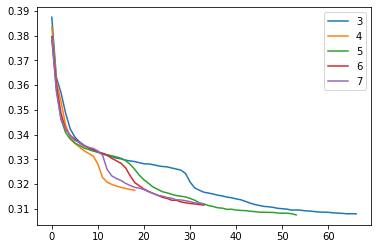

In [147]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [3,4,5,6,7]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_l2_model(n_layers, x_train_final_z.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled_z.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [45]:

kr = regularizers.l2(0.005)


In [ ]:
# evaluate model and plot learning curve of model with given number of layers

num_layers = [8,10,12,14]
for n_layers in num_layers:
    # evaluate model with a given number of layers
    history, result = evaluate_model(n_layers, x_train_final,y_train_final, x_test_scaled, y_test,x_val,y_val)
    print('layers=%d: %.3f' % (n_layers, result))
    # plot learning curve
    plt.plot(history.history['loss'], label=str(n_layers))
plt.legend()
plt.show()

In [ ]:
    history, result = evaluate_model(n_layers, x_train_final.drop(columns=sub_grade_columns,axis=1),
                                     y_train_final, x_test_scaled.drop(columns=sub_grade_columns,axis=1), y_test,
                                     x_val.drop(columns=sub_grade_columns,axis=1),y_val)

In [151]:
kr = regularizers.l2(0.005)
opt = Adam(learning_rate=.001)
L2_model = models.Sequential()
L2_model.add(layers.Dense(50, activation='tanh', kernel_regularizer=kr, input_shape=(53,)))
# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
L2_model.add(layers.Dense(25, kernel_regularizer=kr, activation='tanh'))
# Add an output layer
L2_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
L2_model.compile(optimizer=opt, 
                 loss='binary_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_val = L2_model.fit(x_train_final.drop(columns=sub_grade_columns,axis=1), 
                            y_train_final, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(x_val.drop(columns=sub_grade_columns,axis=1), y_val))

Epoch 1/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.5110 - acc: 0.7994 - val_loss: 0.4664 - val_acc: 0.7990
Epoch 2/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4632 - acc: 0.8010 - val_loss: 0.4709 - val_acc: 0.8012
Epoch 3/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4577 - acc: 0.8015 - val_loss: 0.4535 - val_acc: 0.8042
Epoch 4/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4542 - acc: 0.8019 - val_loss: 0.4573 - val_acc: 0.7946
Epoch 5/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4520 - acc: 0.8020 - val_loss: 0.4566 - val_acc: 0.7945
Epoch 6/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4505 - acc: 0.8022 - val_loss: 0.4523 - val_acc: 0.7977
Epoch 7/150
5358/5358 [==============================] - 10s 2ms/step - loss: 0.4481 - acc: 0.8033 - val_loss: 0.4426 - val_acc: 0.8069
Epoch 8/150
5358/5358 [==============================]

Epoch 61/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4268 - acc: 0.8117 - val_loss: 0.4218 - val_acc: 0.8152
Epoch 62/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4268 - acc: 0.8119 - val_loss: 0.4327 - val_acc: 0.8118
Epoch 63/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4266 - acc: 0.8121 - val_loss: 0.4239 - val_acc: 0.8112
Epoch 64/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4264 - acc: 0.8120 - val_loss: 0.4300 - val_acc: 0.8125
Epoch 65/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4269 - acc: 0.8116 - val_loss: 0.4221 - val_acc: 0.8150
Epoch 66/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4263 - acc: 0.8118 - val_loss: 0.4266 - val_acc: 0.8132
Epoch 67/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4268 - acc: 0.8117 - val_loss: 0.4215 - val_acc: 0.8151
Epoch 68/150
5358/5358 [========================

5358/5358 [==============================] - 8s 2ms/step - loss: 0.4251 - acc: 0.8116 - val_loss: 0.4343 - val_acc: 0.7977
Epoch 122/150
5358/5358 [==============================] - 8s 2ms/step - loss: 0.4255 - acc: 0.8113 - val_loss: 0.4212 - val_acc: 0.8152
Epoch 123/150
5358/5358 [==============================] - 9s 2ms/step - loss: 0.4252 - acc: 0.8117 - val_loss: 0.4663 - val_acc: 0.7657
Epoch 124/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4252 - acc: 0.8116 - val_loss: 0.4229 - val_acc: 0.8112
Epoch 125/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4249 - acc: 0.8117 - val_loss: 0.4219 - val_acc: 0.8149
Epoch 126/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4252 - acc: 0.8115 - val_loss: 0.4326 - val_acc: 0.8116
Epoch 127/150
5358/5358 [==============================] - 8s 1ms/step - loss: 0.4250 - acc: 0.8116 - val_loss: 0.4365 - val_acc: 0.8094
Epoch 128/150
5358/5358 [==============================